<a href="https://colab.research.google.com/github/roxyrong/ml-esg-3/blob/main/eng_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

tqdm_notebook.pandas()

In [6]:
data_df = pd.read_parquet("../dataset/train_df_English_openai_embs.parquet")

In [8]:
## One Time Use

# from openai import OpenAI
# client = OpenAI()

# def create_embedding(text):
#     response = client.embeddings.create(
#         input=text,
#         model="text-embedding-ada-002"
#     )
#     return np.array(response.data[0].embedding)

# data_df["embedding"] = data_df["sentence"].map(create_embedding)

#data_df.to_parquet("../dataset/train_df_English_openai_embs.parquet")

# PCA

In [12]:
feature_vector = np.stack(data_df["embedding"].to_numpy())

max_components = min(768, len(data_df))

explained_variance = []

for components in range(5, max_components + 1, 5):
    pca = PCA(n_components=components)
    pca.fit(feature_vector)
    total_variance = np.sum(pca.explained_variance_ratio_)
    explained_variance.append(total_variance)


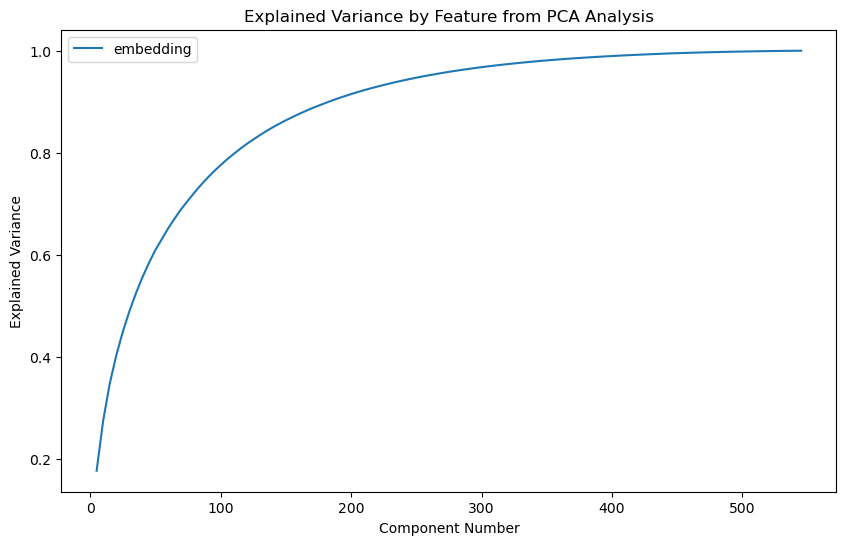

In [13]:
plt.figure(figsize=(10, 6))

plt.plot([i * 5 for i in range(1, len(explained_variance) + 1)],
         explained_variance,
         label="embedding")

plt.title("Explained Variance by Feature from PCA Analysis")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.legend()
plt.show()

# Baseline

In [31]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.4568807339449542
precision: 0.487283857348744
recall: 0.4568807339449542
f1: 0.46632357460630036


Text(0.5, 1.0, 'Confusion Matrix')

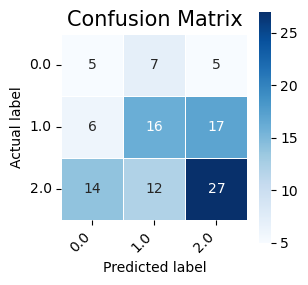

In [32]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)

# Baseline w/ PCA

In [22]:
num_component = 180

In [23]:
accuracys = []
precisions = []
recalls = []
f1s = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"], data_df["impact_length_idx"]):
  X_train = np.stack(data_df.loc[train_idx]["embedding"])
  y_train = np.stack(data_df.loc[train_idx]["impact_length_idx"])
  X_valid = np.stack(data_df.loc[valid_idx]["embedding"])
  y_valid = np.stack(data_df.loc[valid_idx]["impact_length_idx"])
  
  pca = PCA(n_components=num_component)
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  print(np.sum(pca.explained_variance_ratio_))
  X_valid = pca.transform(X_valid)
  
  lr = LogisticRegression(random_state=314,
                          C=1,
                          class_weight="balanced").fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

0.9127405336249191
0.9190742881110496
0.9165702765510442
0.9164683524527146
0.9149965760584838
accuracy: 0.46422018348623856
precision: 0.4952992726767871
recall: 0.46422018348623856
f1: 0.4736868169882065


Text(0.5, 1.0, 'Confusion Matrix')

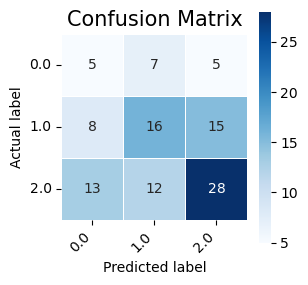

In [24]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)